In [297]:
import torch
import numpy as np
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [298]:

# Define the XOR dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]) - 0.5
y = np.array([0, 1, 1, 0])

# Print the dataset
print("Input:")
print(X)
print("Output:")
print(y)


Input:
[[-0.5 -0.5]
 [-0.5  0.5]
 [ 0.5 -0.5]
 [ 0.5  0.5]]
Output:
[0 1 1 0]


In [275]:
mlp = MLP(input_dim=2, hidden_dim=5, output_dim=2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 400

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = mlp(torch.Tensor(X))
    loss = criterion(outputs, torch.Tensor(y).long())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/400], Loss: 0.7078
Epoch [20/400], Loss: 0.7026
Epoch [30/400], Loss: 0.6981
Epoch [40/400], Loss: 0.6940
Epoch [50/400], Loss: 0.6905
Epoch [60/400], Loss: 0.6874
Epoch [70/400], Loss: 0.6843
Epoch [80/400], Loss: 0.6812
Epoch [90/400], Loss: 0.6782
Epoch [100/400], Loss: 0.6750
Epoch [110/400], Loss: 0.6716
Epoch [120/400], Loss: 0.6680
Epoch [130/400], Loss: 0.6640
Epoch [140/400], Loss: 0.6598
Epoch [150/400], Loss: 0.6553
Epoch [160/400], Loss: 0.6505
Epoch [170/400], Loss: 0.6455
Epoch [180/400], Loss: 0.6401
Epoch [190/400], Loss: 0.6344
Epoch [200/400], Loss: 0.6285
Epoch [210/400], Loss: 0.6223
Epoch [220/400], Loss: 0.6159
Epoch [230/400], Loss: 0.6091
Epoch [240/400], Loss: 0.6021
Epoch [250/400], Loss: 0.5949
Epoch [260/400], Loss: 0.5874
Epoch [270/400], Loss: 0.5797
Epoch [280/400], Loss: 0.5718
Epoch [290/400], Loss: 0.5633
Epoch [300/400], Loss: 0.5538
Epoch [310/400], Loss: 0.5440
Epoch [320/400], Loss: 0.5344
Epoch [330/400], Loss: 0.5248
Epoch [340/400], Lo

In [276]:
# Compute the classification accuracy
y_pred = torch.argmax(mlp(torch.Tensor(X)), dim=1)

In [277]:
import matplotlib.pyplot as plt

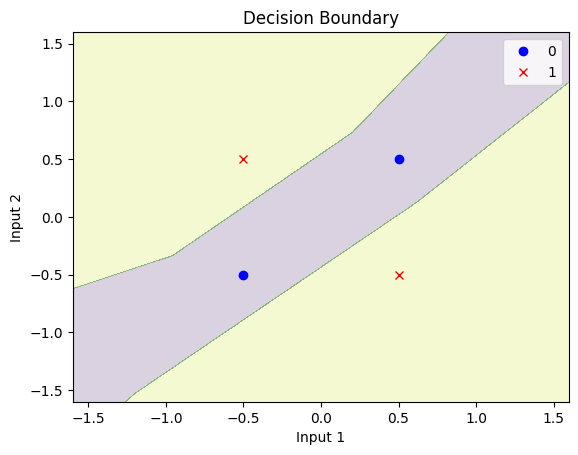

In [278]:
# Generate a grid of points in the input space R2
x_min, x_max = X[:, 0].min() - 1.1, X[:, 0].max() + 1.1
y_min, y_max = X[:, 1].min() - 1.1, X[:, 1].max() + 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001),
                     np.arange(y_min, y_max, 0.001))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Pass each point through the trained MLP model to get the predicted class
with torch.no_grad():
    predictions = torch.argmax(mlp(torch.Tensor(grid_points)), dim=1)

# Plot the grid points and color them according to the predicted class
plt.figure()
plt.contourf(xx, yy, predictions.numpy().reshape(xx.shape), alpha=0.2)

# Overlay the input data points on the plot
plt.plot(X[y==0, 0], X[y==0, 1], 'ob', label='0')
plt.plot(X[y==1, 0], X[y==1, 1], 'xr', label='1')

plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('Decision Boundary')
plt.legend()
plt.show()


In [279]:
## NNs as DTs

In [280]:
params = [p for p in mlp.parameters()]

In [282]:
from copy import deepcopy

W1 = params[0].detach().numpy()
b1 = params[1].detach().numpy()
Q1 = deepcopy(np.concatenate([W1, b1[:, None]], axis=-1))

W2 = params[2].detach().numpy()
b2 = params[3].detach().numpy()
Q2 = deepcopy(np.concatenate([W2, b2[:, None]], axis=-1))

In [299]:
# layer 0
a = []

W_hat = deepcopy(W1)

x = X[0]
for j in range(W1.shape[0]):
    r = np.dot(W1[j, :], x) + b1[j]
    a.append(int(r > 0))

In [322]:
np.array(a) * b1

array([ 4.56154644e-01,  5.67549825e-01,  1.25136226e-04, -8.25961120e-03,
        0.00000000e+00])

In [313]:
W1_eff = W1 * np.array(a)[:, None]

In [316]:
x_out_eff = W1_eff @ x + np.array(a) * b1


In [321]:
mlp(torch.Tensor(X[0]))

tensor([0.6925, 0.1159], grad_fn=<ViewBackward0>)

In [320]:
W2 @ x_out_eff + b2

array([0.69251703, 0.11594372])

In [286]:
W_eff = W2 @ ((W1 * np.array(a)[:, None]))

In [289]:
mlp(torch.Tensor(x))

tensor([0.6925, 0.1159], grad_fn=<ViewBackward0>)

In [290]:
W_eff @ x + b2

array([0.26508028, 0.44886331])

In [294]:
a

[1, 1, 1, 1, 0]

In [296]:
(W1 @ x + b1 > 0)

array([ True,  True,  True,  True, False])

Relu MLP as decision tree:

For relu network that maps R^n -> R^m -> R^p

We have m-many comparisons of first layer.
For 2nd layer, there are 2^m possible filters for W_hat.
So we have 2^m many comparisons..

So about 2^m total nodes.

For a given input/query x, we go through m decisions first. Then that immediatley rules out a bunch of future notes, since our filter is defined. But just for this one query.

Mapping onto boolean fn chapter -- not super obvious how to do so.
- for each input we have m queries we can ask first.
- seeker wants to know if sigma is in m.... a simplex here corresponds to a set of comparisons?
- hmm, not sure what this maps out to.